# Model selection
Using the final csv dataset, this phase trains 3 models (xgboost, random forest, logistic regression).

In [20]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
df = pd.read_csv("../data/final-dataset.csv")

X = df.drop(columns=["is_promoted"])
y = df["is_promoted"]

### Split dataset 80% training and 20% testing

In [22]:
# stratify=y is CRITICAL here to ensure both splits maintain the same ratio of 'is_promoted' employees
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()

((4000, 17),
 (1000, 17),
 is_promoted
 0    3063
 1     937
 Name: count, dtype: int64,
 is_promoted
 0    766
 1    234
 Name: count, dtype: int64)

### Train models

Using class_weight='balanced' for Logistic Regression and Random Forest to mitigate the class imbalance by penalizing misclassification of the minority class. For XGBoost, scale_pos_weight is used to achieve the same effect.

In [23]:
minority_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
minority_ratio

np.float64(3.2689434364994665)

In [24]:
models = {
    'Logistic Regression': LogisticRegression(
        # solver='liblinear',
        class_weight='balanced',
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced', 
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        eval_metric='logloss',
        scale_pos_weight=minority_ratio,
        random_state=42,
        n_jobs=-1
    )
}

Logistic Regression
Classification report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.82      0.62      0.71       766
           1       0.31      0.56      0.40       234

    accuracy                           0.61      1000
   macro avg       0.57      0.59      0.56      1000
weighted avg       0.70      0.61      0.64      1000

ROC AUC Score: 0.6402


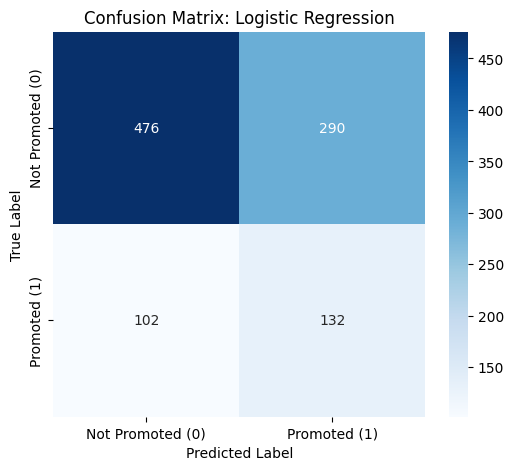

Random Forest
Classification report for Random Forest:

              precision    recall  f1-score   support

           0       0.76      0.99      0.86       766
           1       0.08      0.00      0.01       234

    accuracy                           0.76      1000
   macro avg       0.42      0.49      0.43      1000
weighted avg       0.60      0.76      0.66      1000

ROC AUC Score: 0.6215


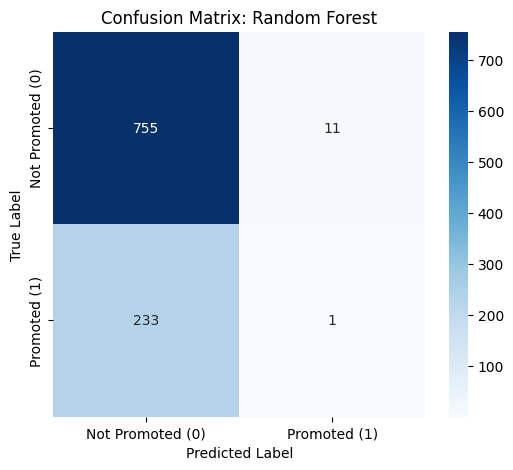

XGBoost
Classification report for XGBoost:

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       766
           1       0.30      0.25      0.27       234

    accuracy                           0.69      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.67      0.69      0.68      1000

ROC AUC Score: 0.5821


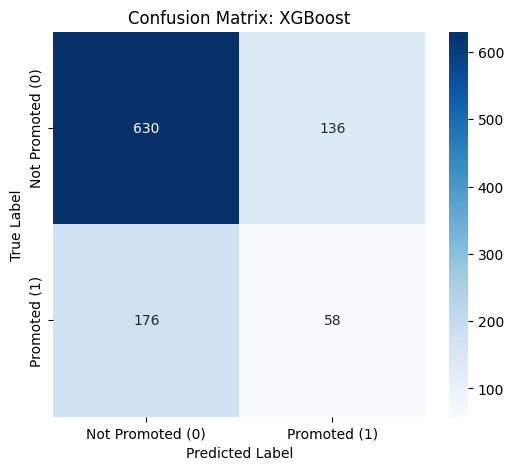

In [25]:
results = {}

for name, model in models.items():
    print(name)
    
    # train the model
    model.fit(X_train, y_train)
    
    # predict on the test set
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # evaluate metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    print(f"Classification report for {name}:\n")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Promoted (0)', 'Promoted (1)'],
                yticklabels=['Not Promoted (0)', 'Promoted (1)'])
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'../confusion_matrix_{name.replace(" ", "_")}.png')
    plt.show()

### Best model
The final selection is made based on the highest F1-Score for the positive class (promotion), as this provides the best balance between precision and recall when accuracy is unreliable.

Results: model and corresponding F1-score for positive class (promotion) 
- XGBoost - 0.27
- RandomForest - 0.01
- Logistic Regression - 0.40

Thus, the best model is Logistic Regression.